In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
len(chars)

26

In [258]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in (w + '.'):
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [257]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(.8 * len(words)) # first 80% for training
n2 = int(.9 * len(words)) # next 10% for dev/validation, and last for test set

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [327]:
# hyper paramters
hidden_layer_size = 200
batch_size = 64
emb_size = 10

In [328]:
# parameters

# we will map the characters (words in the paper), into a 2 dimensional space
g = torch.Generator().manual_seed(132412312)
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((emb_size*block_size, hidden_layer_size), generator=g) # emb_size + block_size
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

In [329]:
def calculate_dataset_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.shape[0], emb_size*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    # also take labels for minibatch
    loss = F.cross_entropy(logits, Y) # more performant, and numerically well-behaved
    return loss

In [330]:
stepi = []
lossi = []

In [337]:
for i in range(50000):
    # make minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], emb_size*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    # also take labels for minibatch
    loss = F.cross_entropy(logits, Ytr[ix]) # more performant, and numerically well-behaved
    
    # clear out
    for p in parameters:
        p.grad = None
        
    # backward
    loss.backward()
    
    # update
    lr = 0.001 if loss <= 2.3 else 0.1
    for p in parameters:
        p.data += -.1 * p.grad

    # record data
    stepi.append(i)
    lossi.append(loss.item())

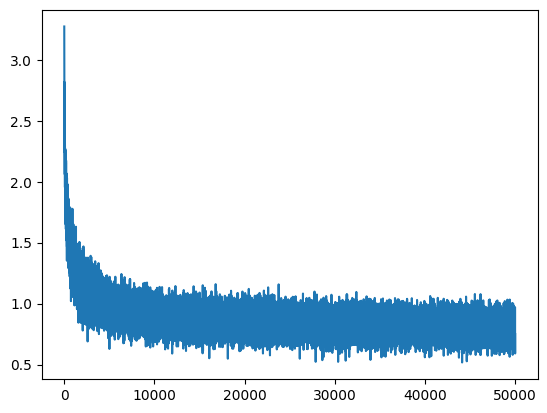

In [333]:
plt.plot(stepi, torch.tensor(lossi).log())

In [338]:
print(f"train loss:\t {calculate_dataset_loss(Xtr, Ytr).item()}")
print(f"dev loss:\t {calculate_dataset_loss(Xdev, Ydev).item()}")

train loss:	 2.163668155670166
dev loss:	 2.214434862136841


1. Encontrar un learning rate general para entrenar el grueso
2. Learning rate decay de un orden de magnitud

In [340]:
g2 = torch.Generator().manual_seed(123123)

In [341]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g2).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

loz.
jeannaree.
brey.
kaveid.
garmain.
kaudah.
kalimann.
elio.
emmatii.
rasrasynn.
kaylaina.
aileihamarah.
dur.
ganna.
eveshoniannasal.
davay.
kenny.
cedsleia.
kelen.
keylumie.
